In [1]:
images_dir = "2019-05_ManualSegmentationsa"

In [2]:
from local_vars import root_folder

from keras.layers import Input
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D

from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose
from keras.models import  Model
from keras.optimizers import Adam, rmsprop
from keras import losses
from keras.layers import concatenate, Add
from keras.utils import to_categorical
import keras.backend as K

import matplotlib.pyplot as plt
import cv2

import numpy as np

import os
import shutil

patch_size = 128

category = True

import keras.utils

import numpy as np
import keras

import scipy


def nvidia_unet(patch_size=128):
    input_ = Input((patch_size, patch_size, 1))
    skips = []
    output = input_
    for shape, filters in zip([5, 3, 3, 3, 3, 3, 3], [16, 32, 64, 64, 64, 64, 64]):
        skips.append(output)
        print(output.shape)
        output= Conv2D(filters, (shape, shape), strides=2, padding="same", activation="relu")(output)
        #output = BatchNormalization()(output)
        #if shape != 7:
        #   output = BatchNormalization()(output)
    for shape, filters in zip([4, 4, 4, 4, 4, 4, 4, 4], [64, 64, 64, 64,32, 16, 2]):
        output = keras.layers.UpSampling2D()(output)
        
        skip_output = skips.pop()
        output = concatenate([output, skip_output], axis=3)
        
        if filters != 2:
            activation = "relu"
        else:
            activation = "softmax"
        output = Conv2D(filters if filters != 2 else 2, (shape, shape), activation=activation, padding="same")(output)
        
        
            
        if filters != 2:
            output = BatchNormalization(momentum=.9)(output)
    assert len(skips) == 0
    return Model([input_], [output])
models = [nvidia_unet() for _ in range(2)]
[model.compile(optimizer=keras.optimizers.adam(), loss= "binary_crossentropy", metrics=["accuracy"]) for model in models]
loss = [[] for _ in range(2)]
models[1].summary()

Using TensorFlow backend.
c:\users\hasti\anaconda3\envs\neuralnets\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


(?, 128, 128, 1)
(?, 64, 64, 16)
(?, 32, 32, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 2, 2, 64)
(?, 128, 128, 1)
(?, 64, 64, 16)
(?, 32, 32, 32)
(?, 16, 16, 64)
(?, 8, 8, 64)
(?, 4, 4, 64)
(?, 2, 2, 64)
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_2 (InputLayer)             (None, 128, 128, 1)   0                                            
____________________________________________________________________________________________________
conv2d_15 (Conv2D)               (None, 64, 64, 16)    416         input_2[0][0]                    
____________________________________________________________________________________________________
conv2d_16 (Conv2D)               (None, 32, 32, 32)    4640        conv2d_15[0][0]                  
_______________________________________________________________________________

In [3]:
data = np.array( np.load(os.path.join(root_folder, images_dir, "ultrasound.npy" )), np.float)
classes = np.array(np.load(os.path.join(root_folder, images_dir, "segmentation.npy")), np.float)
#classes = np.concatenate([classes, 1 - classes], -1)
tdata = np.array( np.load(os.path.join(root_folder, images_dir, "ultrasound-test.npy" )), np.float)
tclasses = np.array(np.load(os.path.join(root_folder, images_dir, "segmentation-test.npy")), np.float)
#tclasses = np.concatenate([tclasses, 1 - tclasses], -1)

In [4]:
def dialateStack(array, iterations):
    return np.array([scipy.ndimage.binary_dilation(y_e, iterations=iterations) for y_e in array])

width = 1
test_y_dialated = dialateStack(tclasses[:, :, :, 0], width)
t_final_x = []
t_final_y = []
for i in range(len(tdata)):

    
    t_final_x.append(cv2.resize(tdata[i], (128, 128)))
    t_final_y.append(cv2.resize(test_y_dialated[i] + 0.0, (128, 128)))
tdata =  np.expand_dims(t_final_x, -1)
test_y_dialated = np.array(t_final_y)

test_y_dialated = np.expand_dims(test_y_dialated, -1)
tclasses_dialated = np.concatenate([test_y_dialated, 1-test_y_dialated], -1)


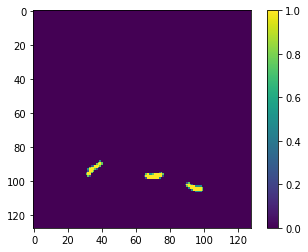

In [5]:
i = np.random.randint(10)
plt.imshow(tclasses_dialated[i, :, :, 0])
plt.colorbar()
plt.show()

In [6]:
from multiprocessing import Queue, Process

from augmentor import prepare_batches

prepared_batches = Queue(maxsize=7)
 
width = 1
y_edge = np.array([scipy.ndimage.binary_dilation(y_e, iterations=width) for y_e in classes])[:, :] * 1.0
threads = []
for _ in range(6):
    p = Process(target=prepare_batches, args=(y_edge, data, prepared_batches))
    
    p.start()
    
    threads = threads + [p]


In [97]:
while True:
    batchx, batchy = prepared_batches.get(block=True, timeout=15)
    print("qsize", prepared_batches.qsize())
    for i in range(1):
        l = models[i].fit(batchx, batchy, validation_data=(tdata, tclasses_dialated), batch_size=len(batchx) // 12)
        loss[i].append(l)

qsize 7
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0095 - acc: 0.8042 - val_loss: 0.0120 - val_acc: 0.9946
qsize 7
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0099 - acc: 0.8010 - val_loss: 0.0118 - val_acc: 0.9946
qsize 7
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0095 - acc: 0.8045 - val_loss: 0.0114 - val_acc: 0.9947
qsize 7
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0099 - acc: 0.8036 - val_loss: 0.0117 - val_acc: 0.9946
qsize 7
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0100 - acc: 0.8018 - val_loss: 0.0130 - val_acc: 0.9945
qsize 7
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1

1362/1362 [==============================] - 1s - loss: 0.0091 - acc: 0.8046 - val_loss: 0.0120 - val_acc: 0.9945
qsize 1
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0083 - acc: 0.8174 - val_loss: 0.0127 - val_acc: 0.9946
qsize 0
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0084 - acc: 0.8196 - val_loss: 0.0126 - val_acc: 0.9946
qsize 1
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0091 - acc: 0.8055 - val_loss: 0.0136 - val_acc: 0.9944
qsize 0
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0094 - acc: 0.8001 - val_loss: 0.0130 - val_acc: 0.9940
qsize 0
Train on 1362 samples, validate on 76 samples
Epoch 1/1
1362/1362 [==============================] - 1s - loss: 0.0099 - acc: 0.7997 - val_loss: 0.0123 - val_acc: 0.9

KeyboardInterrupt: 

In [8]:
for t in threads:
    t.terminate()
    t.join()
    print("blammo")

blammo


In [89]:
result = models[0].predict(batchx)
result[:, 0, 0, 0]=1

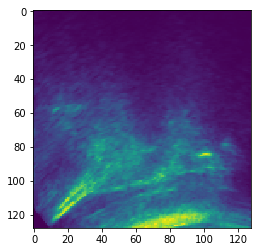

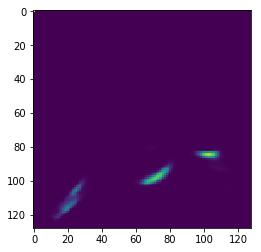

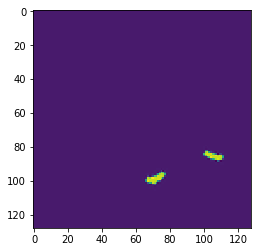

In [96]:
j = np.random.randint(120)
plt.imshow(batchx[j, :, :, 0])
plt.show()
plt.imshow(result[j, :, :, 0])
plt.show()

plt.imshow(batchy[j,:, :, 0])
plt.show()

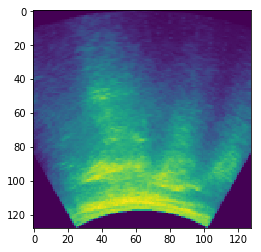

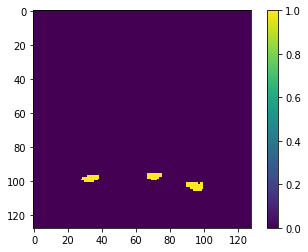

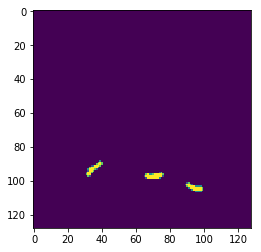

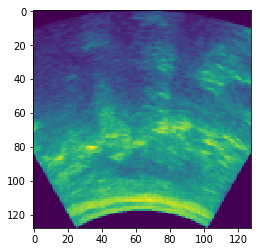

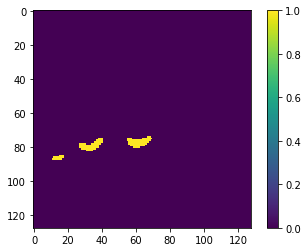

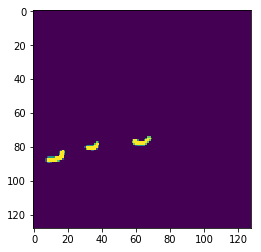

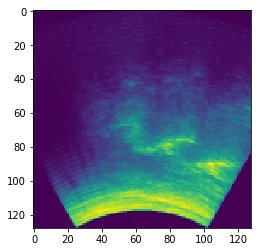

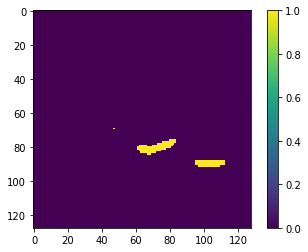

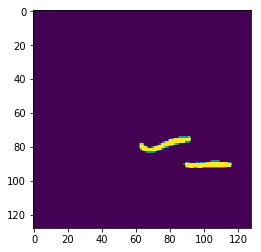

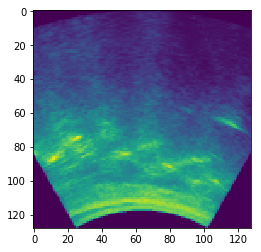

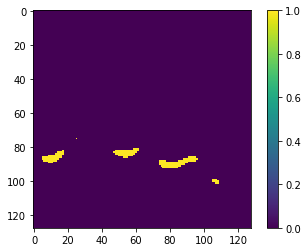

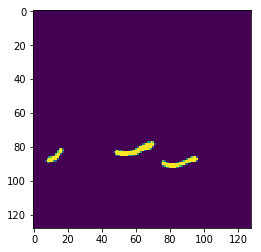

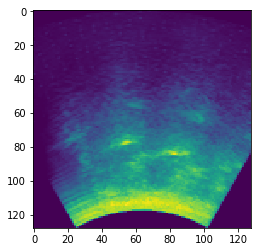

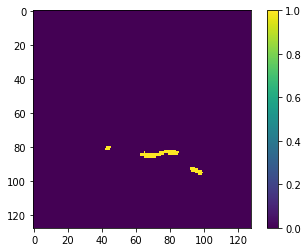

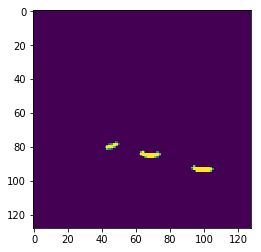

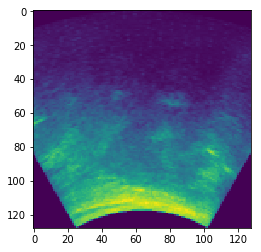

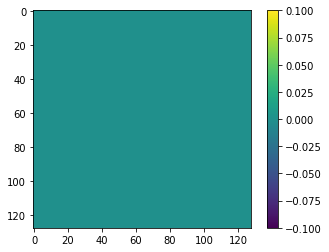

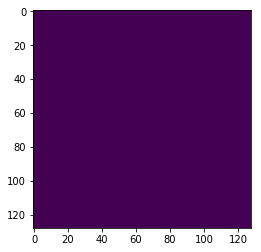

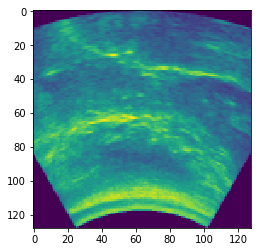

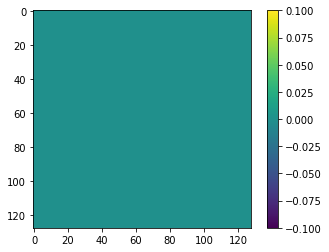

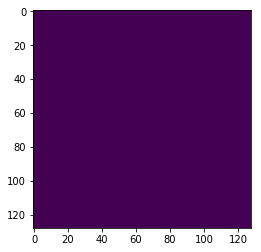

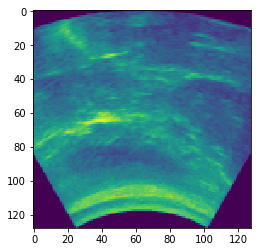

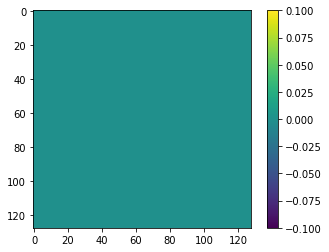

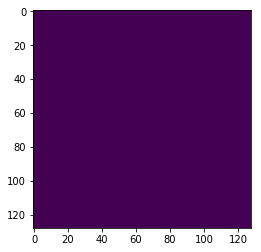

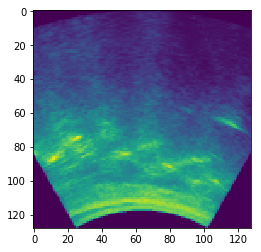

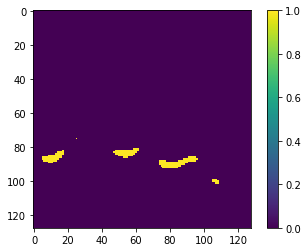

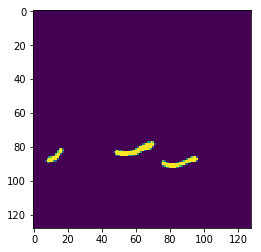

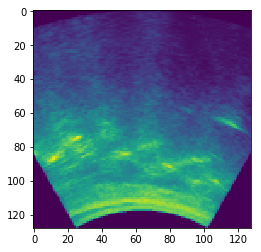

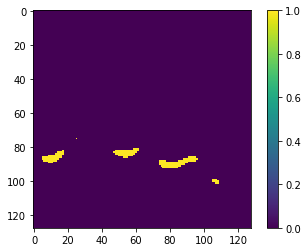

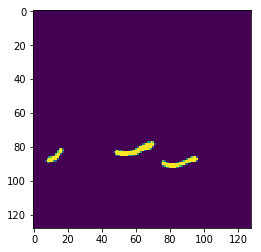

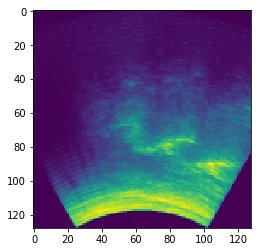

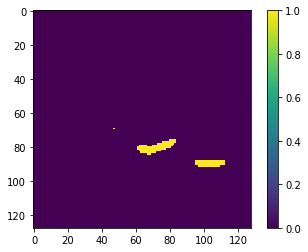

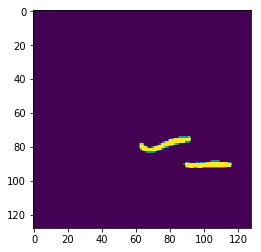

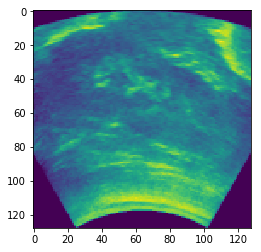

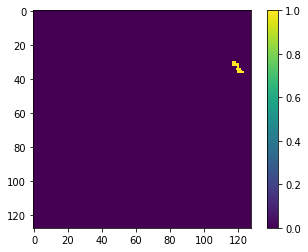

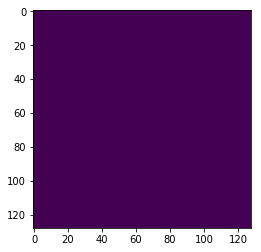

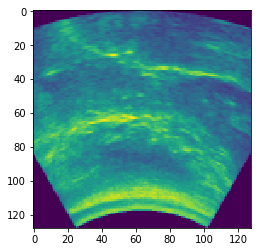

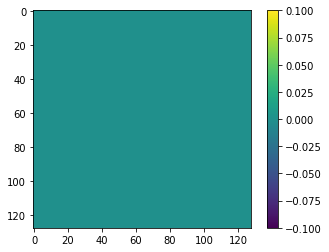

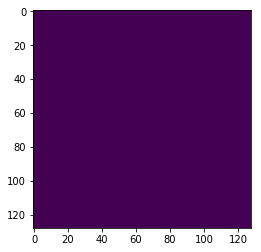

In [127]:
for _ in range(13):
    result = models[0].predict(tdata)

    j = np.random.randint(70)
    plt.imshow(tdata[j, :, :, 0])
    plt.show()
    plt.imshow((result[j, :, :, 0] > .3) * 1)
    plt.colorbar()
    plt.show()

    plt.imshow(tclasses_dialated[j,:, :, 0])
    plt.show()

In [128]:
#models[0].save("5_14_19_model_no_pretrain.h5")
models[0].save("5_14_19_model_no_pretrain_binary_crossentropy.h5")

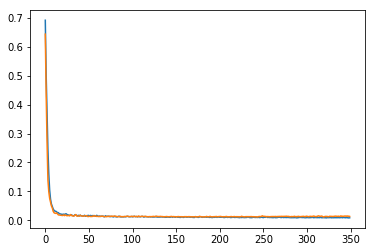

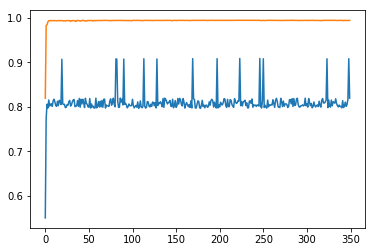

In [129]:
plt.plot([l.history['loss'] for l in loss[0][:]])
plt.plot([l.history['val_loss'] for l in loss[0][:]])
plt.show()
plt.plot([l.history['acc'] for l in loss[0][:]])
plt.plot([l.history['val_acc'] for l in loss[0][:]])
plt.show()

In [130]:
models[0].evaluate(tdata, tclasses_dialated)

32/76 [===========>..................] - ETA: 0s

[0.013155953909613584, 0.9944907458204972]

In [131]:
np.sum(((models[0].predict(tdata) > .5) * 1.0) == tclasses_dialated)

2476648

In [132]:
np.sum(((models[0].predict(tdata) > .5) * 1.0) == tclasses_dialated) /tclasses_dialated.size

0.9944907740542763